In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import dataset for train and test

In [20]:
dataset_train = pd.read_csv('dataset/Google_Stock_Price_Train.csv')
dataset_test = pd.read_csv('dataset/Google_Stock_Price_Test.csv')

dataset_train.head()



,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [21]:
train = dataset_train.loc[:, ['Open']].values
train

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [22]:
# feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train)
train_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

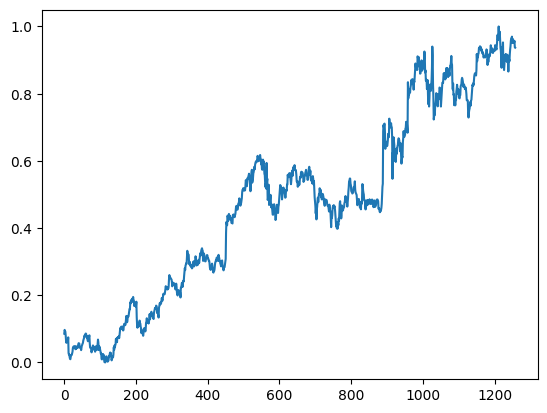

In [23]:
plt.plot(train_scaled)
plt.show()

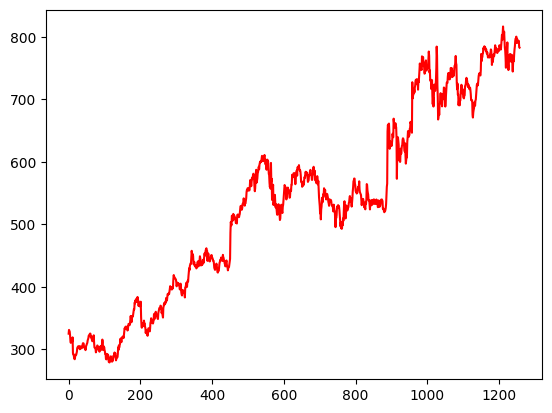

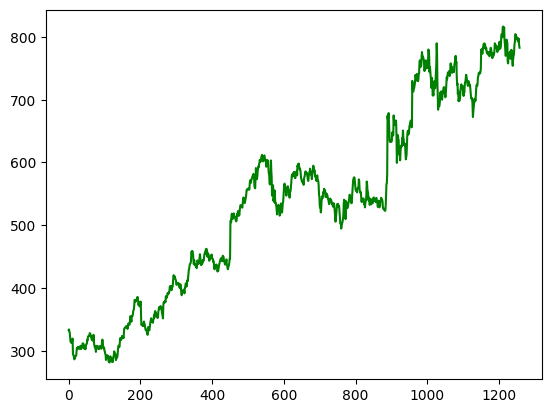

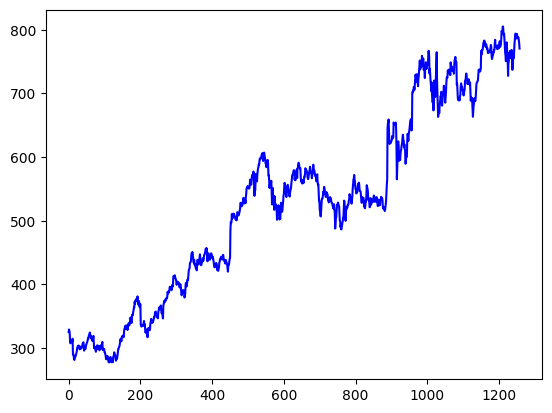

In [24]:
dataset_train['Open'].plot(color='red')
plt.show()
dataset_train['High'].plot(color='green')
plt.show()
dataset_train['Low'].plot(color='blue')
plt.show()


In [25]:
X_train = []
y_train = []
time_step = 60

for i in range(time_step, len(train_scaled)):
    X_train.append(train_scaled[i-time_step:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1198, 60), (1198,))

In [26]:
# reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1198, 60, 1)

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SimpleRNN

model = Sequential()

# adding the RNN layer
model.add(SimpleRNN(units=50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# adding the second RNN layer
model.add(SimpleRNN(units=50, return_sequences = True))
model.add(Dropout(0.2))

# adding the third RNN layer
model.add(SimpleRNN(units=50, return_sequences = True))
model.add(Dropout(0.2))

# adding the fourth RNN layer
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))


# output layer
model.add(Dense(units=1))


# compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)




c:\Users\princ\miniconda3\envs\stock_prediction\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.7294
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.2955
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.2318
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.1600
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1310
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1157
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0919
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0880
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0770
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0643
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0541
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0481
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0435
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0427
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - lo

In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 60, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 60, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,405 (208.62 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,604 (139.08 KB)

In [34]:
# evaluating the model
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [35]:
rl_stock_price = dataset_test.loc[:, ['Open']].values
rl_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [36]:
# predicting the stock price
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_step:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
inputs

array([[0.9299055 ],
       [0.93113327],
       [0.92750577],
       [0.94415507],
       [0.93876032],
       [0.93403527],
       [0.93483518],
       [0.9313937 ],
       [0.94636878],
       [0.96569685],
       [0.97510976],
       [0.95966962],
       [0.97808617],
       [1.        ],
       [0.98076494],
       [0.97083116],
       [0.98450406],
       [0.96054394],
       [0.9371419 ],
       [0.92841729],
       [0.90804747],
       [0.8771858 ],
       [0.92153434],
       [0.93809063],
       [0.93165414],
       [0.95254483],
       [0.88812412],
       [0.88637547],
       [0.87032145],
       [0.88563137],
       [0.90743359],
       [0.91571173],
       [0.89941588],
       [0.91805566],
       [0.9089404 ],
       [0.9024853 ],
       [0.89456061],
       [0.91600938],
       [0.9132934 ],
       [0.88979835],
       [0.86589404],
       [0.89030062],
       [0.90335962],
       [0.89642086],
       [0.91777662],
       [0.93176576],
       [0.94114145],
       [0.957

In [37]:
x_test = []
for i in range(time_step, len(inputs)):
    x_test.append(inputs[i-time_step:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


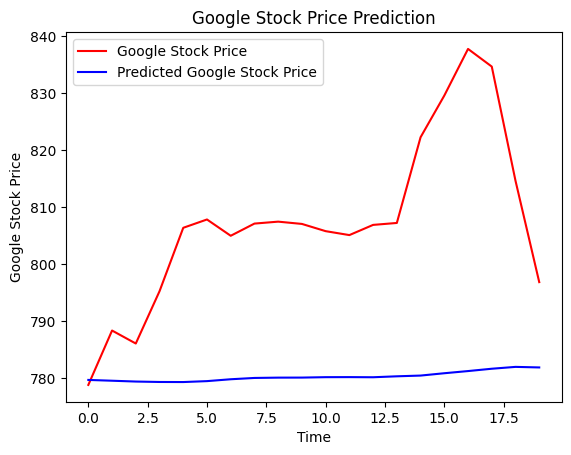

In [39]:
#visualise 
plt.plot(rl_stock_price, color = 'red', label = 'Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()